In [7]:
# MURA Shoulder X-ray Classification with Resilient Blocks and Ensemble

# This block handles all imports required for the code to function properly.
# We use libraries like torch for deep learning, albumentations for augmentations,
# timm for pre-trained models, and OpenCV for image handling.

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model

# We'll use the CPU for this implementation to ensure it runs on all systems
# including restricted or no-GPU environments.
device = torch.device("cpu")
print("Using device:", device)


Using device: cpu


In [8]:
# This block reads image file paths and assigns labels (1 = fracture, 0 = normal).
# It also defines augmentation pipelines for training and normalization for validation/test.

dataset_path = "C:/Users/gouth/Downloads/MURA-v1.1/train/XR_SHOULDER"

def create_dataframe(dataset_path):
    data = []
    for patient in os.listdir(dataset_path):
        patient_path = os.path.join(dataset_path, patient)
        for study in os.listdir(patient_path):
            study_path = os.path.join(patient_path, study)
            label = 1 if "positive" in study else 0
            for image in os.listdir(study_path):
                image_path = os.path.join(study_path, image)
                data.append({"image_path": image_path, "label": label})
    return pd.DataFrame(data)

df = create_dataframe(dataset_path)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)

# Define transformations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [9]:
# Custom dataset class that loads images using OpenCV, applies transformations, and prepares batches.

class MURADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx]["label"]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

    def __len__(self):
        return len(self.df)

batch_size = 32
train_dataset = MURADataset(train_df, transform=train_transform)
valid_dataset = MURADataset(valid_df, transform=valid_transform)
test_dataset = MURADataset(test_df, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



In [10]:
# Define a simple CNN as a baseline and a utility function to load pre-trained models.

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Function to safely load models with pretrained weights (if available)
def get_model(model_name):
    if model_name == 'simplecnn':
        return SimpleCNN()
    try:
        return create_model(model_name, pretrained=True, num_classes=1)
    except Exception as e:
        print(f"⚠️ Failed to load pretrained weights for {model_name}. Using untrained model.")
        return create_model(model_name, pretrained=False, num_classes=1)



In [11]:
# Define training loop, loss function (with class balance), and evaluation logic.

def get_criterion():
    pos_weight = torch.tensor([len(train_df[train_df.label == 0]) / len(train_df[train_df.label == 1])]).to(device)
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training logic with validation accuracy tracking and model saving
def train_model(model, model_name, train_loader, valid_loader, epochs=25):
    model = model.to(device)
    criterion = get_criterion()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                preds = torch.sigmoid(outputs) > 0.5
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = 100 * correct / total
        print(f"{model_name} Validation Accuracy: {val_acc:.2f}%")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
        scheduler.step()
    return model

# Evaluation logic with accuracy, classification report, and confusion matrix
def evaluate_model(model, model_name, return_preds=False):
    model.load_state_dict(torch.load(f"best_{model_name}.pth", map_location=device))
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            pred = torch.sigmoid(outputs).cpu().numpy()[0][0]
            test_preds.append(pred)
            test_labels.append(labels.item())
    binary_preds = [int(p > 0.5) for p in test_preds]
    acc = 100 * np.mean(np.array(binary_preds) == np.array(test_labels))
    print(f"\n{model_name} Test Accuracy: {acc:.2f}%")
    print(classification_report(test_labels, binary_preds, target_names=["Normal", "Fracture"]))
    cm = confusion_matrix(test_labels, binary_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fracture'], yticklabels=['Normal', 'Fracture'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    if return_preds:
        return test_preds, test_labels, acc
    return acc



🚀 Starting: efficientnet_b0


efficientnet_b0 - Epoch 1/25: 100%|██████████████████████████████████████████████████| 184/184 [24:31<00:00,  8.00s/it]


efficientnet_b0 Validation Accuracy: 72.97%


efficientnet_b0 - Epoch 2/25: 100%|██████████████████████████████████████████████████| 184/184 [22:39<00:00,  7.39s/it]


efficientnet_b0 Validation Accuracy: 73.87%


efficientnet_b0 - Epoch 3/25: 100%|██████████████████████████████████████████████████| 184/184 [16:48<00:00,  5.48s/it]


efficientnet_b0 Validation Accuracy: 74.70%


efficientnet_b0 - Epoch 4/25: 100%|██████████████████████████████████████████████████| 184/184 [15:25<00:00,  5.03s/it]


efficientnet_b0 Validation Accuracy: 76.49%


efficientnet_b0 - Epoch 5/25: 100%|██████████████████████████████████████████████████| 184/184 [15:26<00:00,  5.04s/it]


efficientnet_b0 Validation Accuracy: 76.73%


efficientnet_b0 - Epoch 6/25: 100%|██████████████████████████████████████████████████| 184/184 [16:16<00:00,  5.31s/it]


efficientnet_b0 Validation Accuracy: 77.09%


efficientnet_b0 - Epoch 7/25: 100%|██████████████████████████████████████████████████| 184/184 [17:50<00:00,  5.82s/it]


efficientnet_b0 Validation Accuracy: 78.94%


efficientnet_b0 - Epoch 8/25: 100%|██████████████████████████████████████████████████| 184/184 [17:48<00:00,  5.81s/it]


efficientnet_b0 Validation Accuracy: 77.09%


efficientnet_b0 - Epoch 9/25: 100%|██████████████████████████████████████████████████| 184/184 [17:29<00:00,  5.71s/it]


efficientnet_b0 Validation Accuracy: 78.10%


efficientnet_b0 - Epoch 10/25: 100%|█████████████████████████████████████████████████| 184/184 [18:58<00:00,  6.19s/it]


efficientnet_b0 Validation Accuracy: 78.46%


efficientnet_b0 - Epoch 11/25: 100%|█████████████████████████████████████████████████| 184/184 [15:56<00:00,  5.20s/it]


efficientnet_b0 Validation Accuracy: 78.10%


efficientnet_b0 - Epoch 12/25: 100%|█████████████████████████████████████████████████| 184/184 [15:31<00:00,  5.06s/it]


efficientnet_b0 Validation Accuracy: 77.80%


efficientnet_b0 - Epoch 13/25: 100%|█████████████████████████████████████████████████| 184/184 [15:46<00:00,  5.15s/it]


efficientnet_b0 Validation Accuracy: 76.73%


efficientnet_b0 - Epoch 14/25: 100%|█████████████████████████████████████████████████| 184/184 [15:54<00:00,  5.19s/it]


efficientnet_b0 Validation Accuracy: 75.95%


efficientnet_b0 - Epoch 15/25: 100%|█████████████████████████████████████████████████| 184/184 [15:29<00:00,  5.05s/it]


efficientnet_b0 Validation Accuracy: 75.78%


efficientnet_b0 - Epoch 16/25: 100%|█████████████████████████████████████████████████| 184/184 [15:40<00:00,  5.11s/it]


efficientnet_b0 Validation Accuracy: 75.72%


efficientnet_b0 - Epoch 17/25: 100%|█████████████████████████████████████████████████| 184/184 [15:30<00:00,  5.06s/it]


efficientnet_b0 Validation Accuracy: 77.15%


efficientnet_b0 - Epoch 18/25: 100%|█████████████████████████████████████████████████| 184/184 [15:36<00:00,  5.09s/it]


efficientnet_b0 Validation Accuracy: 76.73%


efficientnet_b0 - Epoch 19/25: 100%|█████████████████████████████████████████████████| 184/184 [15:39<00:00,  5.10s/it]


efficientnet_b0 Validation Accuracy: 77.68%


efficientnet_b0 - Epoch 20/25: 100%|█████████████████████████████████████████████████| 184/184 [15:47<00:00,  5.15s/it]


efficientnet_b0 Validation Accuracy: 76.73%


efficientnet_b0 - Epoch 21/25: 100%|█████████████████████████████████████████████████| 184/184 [15:35<00:00,  5.08s/it]


efficientnet_b0 Validation Accuracy: 79.12%


efficientnet_b0 - Epoch 22/25: 100%|█████████████████████████████████████████████████| 184/184 [15:42<00:00,  5.12s/it]


efficientnet_b0 Validation Accuracy: 77.45%


efficientnet_b0 - Epoch 23/25: 100%|█████████████████████████████████████████████████| 184/184 [15:33<00:00,  5.07s/it]


efficientnet_b0 Validation Accuracy: 77.74%


efficientnet_b0 - Epoch 24/25: 100%|█████████████████████████████████████████████████| 184/184 [15:48<00:00,  5.16s/it]


efficientnet_b0 Validation Accuracy: 76.07%


efficientnet_b0 - Epoch 25/25: 100%|█████████████████████████████████████████████████| 184/184 [15:40<00:00,  5.11s/it]


efficientnet_b0 Validation Accuracy: 78.58%

efficientnet_b0 Test Accuracy: 79.47%
              precision    recall  f1-score   support

      Normal       0.76      0.89      0.82       431
    Fracture       0.85      0.70      0.77       407

    accuracy                           0.79       838
   macro avg       0.80      0.79      0.79       838
weighted avg       0.80      0.79      0.79       838



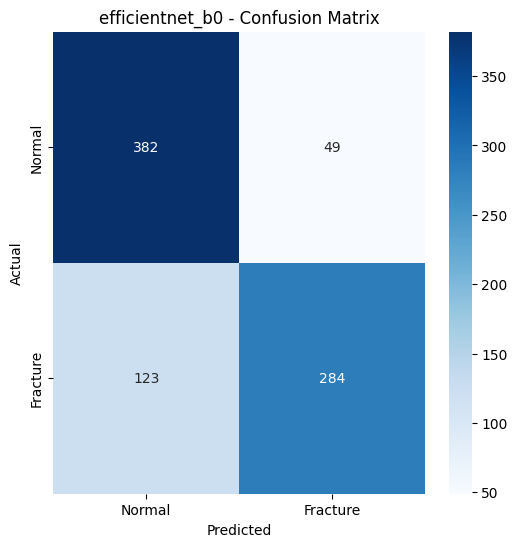


🚀 Starting: resnet50


resnet50 - Epoch 1/25: 100%|█████████████████████████████████████████████████████████| 184/184 [38:55<00:00, 12.69s/it]


resnet50 Validation Accuracy: 71.00%


resnet50 - Epoch 2/25: 100%|█████████████████████████████████████████████████████████| 184/184 [37:55<00:00, 12.37s/it]


resnet50 Validation Accuracy: 73.69%


resnet50 - Epoch 3/25: 100%|█████████████████████████████████████████████████████████| 184/184 [39:01<00:00, 12.73s/it]


resnet50 Validation Accuracy: 74.22%


resnet50 - Epoch 4/25: 100%|█████████████████████████████████████████████████████████| 184/184 [38:01<00:00, 12.40s/it]


resnet50 Validation Accuracy: 73.75%


resnet50 - Epoch 5/25: 100%|█████████████████████████████████████████████████████████| 184/184 [37:23<00:00, 12.19s/it]


resnet50 Validation Accuracy: 74.64%


resnet50 - Epoch 6/25: 100%|█████████████████████████████████████████████████████████| 184/184 [37:15<00:00, 12.15s/it]


resnet50 Validation Accuracy: 76.91%


resnet50 - Epoch 7/25: 100%|█████████████████████████████████████████████████████████| 184/184 [37:54<00:00, 12.36s/it]


resnet50 Validation Accuracy: 76.43%


resnet50 - Epoch 8/25: 100%|█████████████████████████████████████████████████████████| 184/184 [37:24<00:00, 12.20s/it]


resnet50 Validation Accuracy: 77.80%


resnet50 - Epoch 9/25: 100%|█████████████████████████████████████████████████████████| 184/184 [37:31<00:00, 12.24s/it]


resnet50 Validation Accuracy: 77.57%


resnet50 - Epoch 10/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:43<00:00, 12.30s/it]


resnet50 Validation Accuracy: 77.80%


resnet50 - Epoch 11/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:41<00:00, 12.29s/it]


resnet50 Validation Accuracy: 77.80%


resnet50 - Epoch 12/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:50<00:00, 12.34s/it]


resnet50 Validation Accuracy: 78.10%


resnet50 - Epoch 13/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:59<00:00, 12.39s/it]


resnet50 Validation Accuracy: 77.33%


resnet50 - Epoch 14/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:53<00:00, 12.36s/it]


resnet50 Validation Accuracy: 77.27%


resnet50 - Epoch 15/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:36<00:00, 12.26s/it]


resnet50 Validation Accuracy: 74.58%


resnet50 - Epoch 16/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:22<00:00, 12.19s/it]


resnet50 Validation Accuracy: 73.03%


resnet50 - Epoch 17/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:55<00:00, 12.36s/it]


resnet50 Validation Accuracy: 74.82%


resnet50 - Epoch 18/25: 100%|████████████████████████████████████████████████████████| 184/184 [37:52<00:00, 12.35s/it]


resnet50 Validation Accuracy: 74.34%


resnet50 - Epoch 19/25: 100%|████████████████████████████████████████████████████████| 184/184 [38:23<00:00, 12.52s/it]


resnet50 Validation Accuracy: 75.60%


resnet50 - Epoch 20/25: 100%|████████████████████████████████████████████████████████| 184/184 [38:13<00:00, 12.46s/it]


resnet50 Validation Accuracy: 72.97%


resnet50 - Epoch 21/25: 100%|████████████████████████████████████████████████████████| 184/184 [38:56<00:00, 12.70s/it]


resnet50 Validation Accuracy: 72.97%


resnet50 - Epoch 22/25: 100%|████████████████████████████████████████████████████████| 184/184 [39:46<00:00, 12.97s/it]


resnet50 Validation Accuracy: 75.00%


resnet50 - Epoch 23/25: 100%|████████████████████████████████████████████████████████| 184/184 [38:20<00:00, 12.51s/it]


resnet50 Validation Accuracy: 73.75%


resnet50 - Epoch 24/25: 100%|████████████████████████████████████████████████████████| 184/184 [39:25<00:00, 12.85s/it]


resnet50 Validation Accuracy: 76.79%


resnet50 - Epoch 25/25: 100%|████████████████████████████████████████████████████████| 184/184 [38:39<00:00, 12.61s/it]


resnet50 Validation Accuracy: 76.55%

resnet50 Test Accuracy: 80.43%
              precision    recall  f1-score   support

      Normal       0.79      0.84      0.82       431
    Fracture       0.82      0.76      0.79       407

    accuracy                           0.80       838
   macro avg       0.81      0.80      0.80       838
weighted avg       0.81      0.80      0.80       838



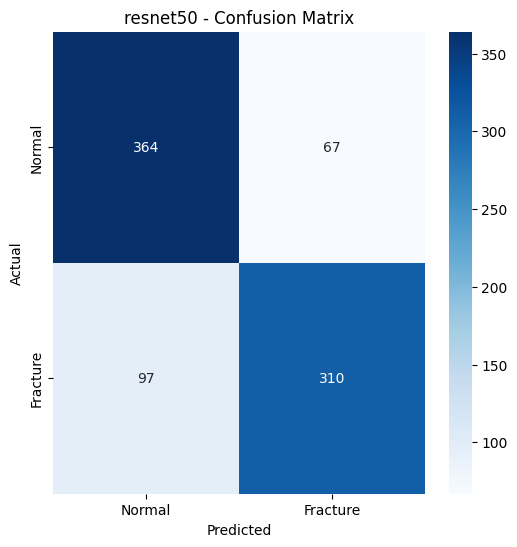


🚀 Starting: densenet121


densenet121 - Epoch 1/25: 100%|████████████████████████████████████████████████████| 184/184 [2:23:00<00:00, 46.63s/it]


densenet121 Validation Accuracy: 64.62%


densenet121 - Epoch 2/25: 100%|████████████████████████████████████████████████████| 184/184 [2:24:21<00:00, 47.08s/it]


densenet121 Validation Accuracy: 64.68%


densenet121 - Epoch 3/25: 100%|████████████████████████████████████████████████████| 184/184 [2:24:03<00:00, 46.98s/it]


densenet121 Validation Accuracy: 68.32%


densenet121 - Epoch 4/25: 100%|████████████████████████████████████████████████████| 184/184 [2:24:55<00:00, 47.26s/it]


densenet121 Validation Accuracy: 70.11%


densenet121 - Epoch 5/25: 100%|████████████████████████████████████████████████████| 184/184 [2:23:56<00:00, 46.94s/it]


densenet121 Validation Accuracy: 69.93%


densenet121 - Epoch 6/25: 100%|████████████████████████████████████████████████████| 184/184 [2:22:03<00:00, 46.33s/it]


densenet121 Validation Accuracy: 73.51%


densenet121 - Epoch 7/25: 100%|████████████████████████████████████████████████████| 184/184 [2:26:39<00:00, 47.82s/it]


densenet121 Validation Accuracy: 75.36%


densenet121 - Epoch 8/25: 100%|████████████████████████████████████████████████████| 184/184 [2:25:14<00:00, 47.36s/it]


densenet121 Validation Accuracy: 76.01%


densenet121 - Epoch 9/25: 100%|████████████████████████████████████████████████████| 184/184 [2:25:59<00:00, 47.61s/it]


densenet121 Validation Accuracy: 76.19%


densenet121 - Epoch 10/25: 100%|███████████████████████████████████████████████████| 184/184 [2:25:53<00:00, 47.57s/it]


densenet121 Validation Accuracy: 77.74%


densenet121 - Epoch 11/25: 100%|███████████████████████████████████████████████████| 184/184 [2:26:11<00:00, 47.67s/it]


densenet121 Validation Accuracy: 77.86%


densenet121 - Epoch 12/25: 100%|██████████████████████████████████████████████████| 184/184 [9:49:46<00:00, 192.32s/it]


densenet121 Validation Accuracy: 77.45%


densenet121 - Epoch 13/25: 100%|███████████████████████████████████████████████████| 184/184 [2:20:27<00:00, 45.80s/it]


densenet121 Validation Accuracy: 76.73%


densenet121 - Epoch 14/25: 100%|███████████████████████████████████████████████████| 184/184 [2:19:06<00:00, 45.36s/it]


densenet121 Validation Accuracy: 76.25%


densenet121 - Epoch 15/25: 100%|███████████████████████████████████████████████████| 184/184 [2:20:17<00:00, 45.75s/it]


densenet121 Validation Accuracy: 75.42%


densenet121 - Epoch 16/25: 100%|███████████████████████████████████████████████████| 184/184 [2:26:55<00:00, 47.91s/it]


densenet121 Validation Accuracy: 76.67%


densenet121 - Epoch 17/25: 100%|███████████████████████████████████████████████████| 184/184 [2:16:26<00:00, 44.49s/it]


densenet121 Validation Accuracy: 73.93%


densenet121 - Epoch 18/25: 100%|███████████████████████████████████████████████████| 184/184 [2:17:09<00:00, 44.73s/it]


densenet121 Validation Accuracy: 72.43%


densenet121 - Epoch 19/25: 100%|███████████████████████████████████████████████████| 184/184 [2:18:43<00:00, 45.24s/it]


densenet121 Validation Accuracy: 74.76%


densenet121 - Epoch 20/25: 100%|███████████████████████████████████████████████████| 184/184 [2:16:14<00:00, 44.43s/it]


densenet121 Validation Accuracy: 75.66%


densenet121 - Epoch 21/25: 100%|███████████████████████████████████████████████████| 184/184 [2:16:50<00:00, 44.62s/it]


densenet121 Validation Accuracy: 72.37%


densenet121 - Epoch 22/25: 100%|███████████████████████████████████████████████████| 184/184 [2:14:17<00:00, 43.79s/it]


densenet121 Validation Accuracy: 74.70%


densenet121 - Epoch 23/25: 100%|███████████████████████████████████████████████████| 184/184 [2:16:00<00:00, 44.35s/it]


densenet121 Validation Accuracy: 74.05%


densenet121 - Epoch 24/25: 100%|███████████████████████████████████████████████████| 184/184 [2:17:16<00:00, 44.76s/it]


densenet121 Validation Accuracy: 72.02%


densenet121 - Epoch 25/25: 100%|███████████████████████████████████████████████████| 184/184 [2:19:02<00:00, 45.34s/it]


densenet121 Validation Accuracy: 76.07%

densenet121 Test Accuracy: 80.31%
              precision    recall  f1-score   support

      Normal       0.79      0.84      0.81       431
    Fracture       0.82      0.77      0.79       407

    accuracy                           0.80       838
   macro avg       0.80      0.80      0.80       838
weighted avg       0.80      0.80      0.80       838



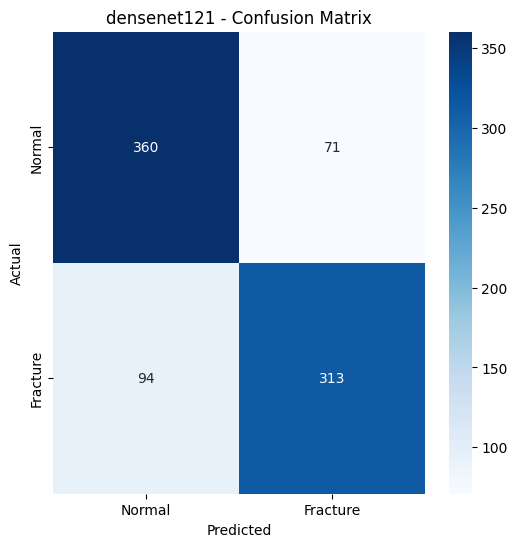


🚀 Starting: simplecnn


simplecnn - Epoch 1/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.21it/s]


simplecnn Validation Accuracy: 56.68%


simplecnn - Epoch 2/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:31<00:00,  1.22it/s]


simplecnn Validation Accuracy: 59.13%


simplecnn - Epoch 3/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:33<00:00,  1.20it/s]


simplecnn Validation Accuracy: 61.34%


simplecnn - Epoch 4/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:33<00:00,  1.20it/s]


simplecnn Validation Accuracy: 60.80%


simplecnn - Epoch 5/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.20it/s]


simplecnn Validation Accuracy: 60.44%


simplecnn - Epoch 6/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.21it/s]


simplecnn Validation Accuracy: 61.63%


simplecnn - Epoch 7/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:33<00:00,  1.20it/s]


simplecnn Validation Accuracy: 61.99%


simplecnn - Epoch 8/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.20it/s]


simplecnn Validation Accuracy: 62.29%


simplecnn - Epoch 9/25: 100%|████████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.21it/s]


simplecnn Validation Accuracy: 62.41%


simplecnn - Epoch 10/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.20it/s]


simplecnn Validation Accuracy: 62.47%


simplecnn - Epoch 11/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:32<00:00,  1.21it/s]


simplecnn Validation Accuracy: 62.47%


simplecnn - Epoch 12/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:33<00:00,  1.20it/s]


simplecnn Validation Accuracy: 62.77%


simplecnn - Epoch 13/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:31<00:00,  1.22it/s]


simplecnn Validation Accuracy: 62.17%


simplecnn - Epoch 14/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:34<00:00,  1.19it/s]


simplecnn Validation Accuracy: 61.22%


simplecnn - Epoch 15/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:33<00:00,  1.20it/s]


simplecnn Validation Accuracy: 62.23%


simplecnn - Epoch 16/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:31<00:00,  1.21it/s]


simplecnn Validation Accuracy: 61.16%


simplecnn - Epoch 17/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:31<00:00,  1.21it/s]


simplecnn Validation Accuracy: 61.52%


simplecnn - Epoch 18/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:31<00:00,  1.21it/s]


simplecnn Validation Accuracy: 61.28%


simplecnn - Epoch 19/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:33<00:00,  1.20it/s]


simplecnn Validation Accuracy: 61.22%


simplecnn - Epoch 20/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:35<00:00,  1.18it/s]


simplecnn Validation Accuracy: 60.26%


simplecnn - Epoch 21/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:36<00:00,  1.17it/s]


simplecnn Validation Accuracy: 60.20%


simplecnn - Epoch 22/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:34<00:00,  1.19it/s]


simplecnn Validation Accuracy: 60.02%


simplecnn - Epoch 23/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:35<00:00,  1.19it/s]


simplecnn Validation Accuracy: 60.74%


simplecnn - Epoch 24/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:34<00:00,  1.19it/s]


simplecnn Validation Accuracy: 61.46%


simplecnn - Epoch 25/25: 100%|███████████████████████████████████████████████████████| 184/184 [02:35<00:00,  1.19it/s]


simplecnn Validation Accuracy: 59.67%

simplecnn Test Accuracy: 63.84%
              precision    recall  f1-score   support

      Normal       0.68      0.56      0.61       431
    Fracture       0.61      0.72      0.66       407

    accuracy                           0.64       838
   macro avg       0.64      0.64      0.64       838
weighted avg       0.64      0.64      0.64       838



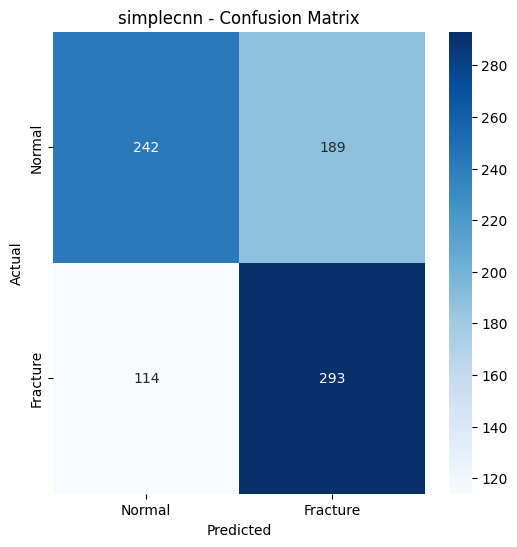

In [12]:
# This block trains each model one-by-one and stores predictions for ensemble use later.
model_names = ['efficientnet_b0', 'resnet50', 'densenet121', 'simplecnn']
all_accuracies = {}
all_model_probs = []
true_labels = None

for model_name in model_names:
    print(f"\n🚀 Starting: {model_name}")
    model = get_model(model_name)
    trained_model = train_model(model, model_name, train_loader, valid_loader, epochs=25)
    probs, true_labels, acc = evaluate_model(trained_model, model_name, return_preds=True)
    all_accuracies[model_name] = acc
    all_model_probs.append(probs)


🌟 Ensemble Test Accuracy: 81.15%
              precision    recall  f1-score   support

      Normal       0.79      0.86      0.82       431
    Fracture       0.84      0.76      0.80       407

    accuracy                           0.81       838
   macro avg       0.81      0.81      0.81       838
weighted avg       0.81      0.81      0.81       838



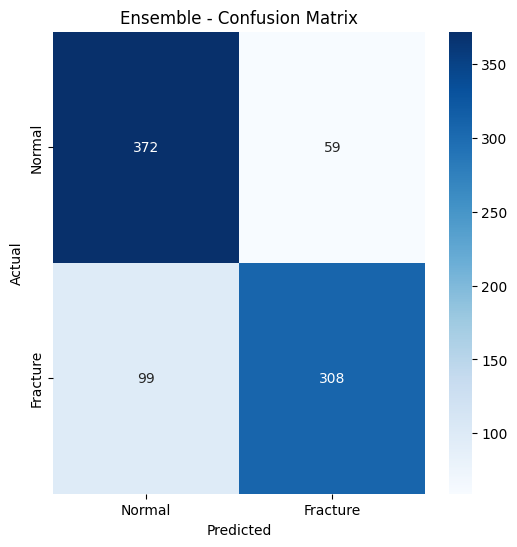


📊 === Summary of Model Accuracies ===
efficientnet_b0: 79.47%
resnet50: 80.43%
densenet121: 80.31%
simplecnn: 63.84%
Ensemble: 81.15%


In [13]:
# Averages predictions from all models and computes final accuracy.
ensemble_probs = np.mean(np.array(all_model_probs), axis=0)
ensemble_preds = (ensemble_probs > 0.5).astype(int)
ensemble_acc = 100 * np.mean(np.array(ensemble_preds) == np.array(true_labels))

print(f"\n🌟 Ensemble Test Accuracy: {ensemble_acc:.2f}%")
print(classification_report(true_labels, ensemble_preds, target_names=["Normal", "Fracture"]))
cm = confusion_matrix(true_labels, ensemble_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fracture'], yticklabels=['Normal', 'Fracture'])
plt.title('Ensemble - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Final accuracy summary
print("\n📊 === Summary of Model Accuracies ===")
for name, acc in all_accuracies.items():
    print(f"{name}: {acc:.2f}%")
print(f"Ensemble: {ensemble_acc:.2f}%")
